### Clean And Analyze Employee Exit Surveys

We'll work with exit surveys from employees of the Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) institute in Queensland, Australia.

In this project, we'll play the role of data analyst and pretend our stakeholders want to know the following:

- Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?
- Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

They want us to combine the results for both surveys to answer these questions. However, although both used the same survey template, one of them customized some of the answers. A data dictionary wasn't provided with the dataset. For this project, we'll use general knowledge to define the columns.

In [1]:
import pandas as pd
import numpy as np 

In [2]:
dete_survey = pd.read_csv('data/dete_survey.csv', na_values='Not Stated')
tafe_survey = pd.read_csv('data/tafe_survey.csv', encoding='Latin-1')

In [3]:
print(dete_survey.info(),'\n\n')
print(tafe_survey.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
ID                                     822 non-null int64
SeparationType                         822 non-null object
Cease Date                             788 non-null object
DETE Start Date                        749 non-null float64
Role Start Date                        724 non-null float64
Position                               817 non-null object
Classification                         455 non-null object
Region                                 717 non-null object
Business Unit                          126 non-null object
Employment Status                      817 non-null object
Career move to public sector           822 non-null bool
Career move to private sector          822 non-null bool
Interpersonal conflicts                822 non-null bool
Job dissatisfaction                    822 non-null bool
Dissatisfaction with the department    822 non-null bool
Physical work envir

In [4]:
print(dete_survey.columns.isnull().sum())
print(tafe_survey.columns.isnull().sum())

0
0


In [5]:
print(dete_survey.columns.value_counts(),'\n\n')
print(tafe_survey.columns.value_counts())

Lack of job security                   1
Study/Travel                           1
My say                                 1
NESB                                   1
ID                                     1
Stress and pressure support            1
Interpersonal conflicts                1
Information                            1
Business Unit                          1
DETE Start Date                        1
Aboriginal                             1
None of the above                      1
Employment Status                      1
Dissatisfaction with the department    1
Career move to private sector          1
Ill Health                             1
Employment conditions                  1
Traumatic incident                     1
Professional Development               1
Career Aspirations                     1
Health & Safety                        1
Initiative                             1
Lack of recognition                    1
Physical environment                   1
Workplace issue 

We can first make the following observations:

- The dete_survey dataframe contains 'Not Stated' values that indicate values are missing, but they aren't represented as NaN. (changed in cell 3)
- Both the dete_survey and tafe_survey dataframes contain many columns that we don't need to complete our analysis.
- Each dataframe contains many of the same columns, but the column names are different.
- There are multiple columns/answers that indicate an employee resigned because they were dissatisfied.

In [6]:
# let's drop some columns from each dataframe that we won't use in our analysis to make the dataframes easier to work with.
dete_drop = dete_survey.columns[28:49]
tafe_drop = tafe_survey.columns[17:66]
dete_df = dete_survey.drop(dete_drop, axis=1)
tafe_df = tafe_survey.drop(tafe_drop, axis=1)

In [7]:
# Rename the columns in the dete_df
dete_df.columns = dete_df.columns.str.lower().str.strip().str.replace(' ','_')
tafe_df = tafe_df.rename(columns={'Record ID': 'id',
'CESSATION YEAR': 'cease_date',
'Reason for ceasing employment': 'separationtype',
'Gender. What is your Gender?': 'gender',
'CurrentAge. Current Age': 'age',
'Employment Type. Employment Type': 'employment_status',
'Classification. Classification': 'position',
'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'})

If we look at the unique values in the separationtype columns in each dataframe, we'll see that each contains a couple of different separation types. For this project, we'll only analyze survey respondents who resigned, so their separation type contains the string 'Resignation'.

In [8]:
dete_df['separationtype'].value_counts()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64

In [9]:
tafe_df['separationtype'].value_counts()

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64

Note that dete_df dataframe contains multiple separation types with the string 'Resignation':

- Resignation-Other reasons
- Resignation-Other employer
- Resignation-Move overseas/interstate

In [10]:
# create dataframes that contain only resignations
reasons = dete_df.loc[(dete_df['separationtype'] == 'Resignation-Other reasons') | (dete_df['separationtype'] == 'Resignation-Other employer') | (dete_df['separationtype'] == 'Resignation-Move overseas/interstate')]
dete_resignations = dete_df.loc[(dete_df['separationtype'] == 'Resignation-Other reasons') | (dete_df['separationtype'] == 'Resignation-Other employer') | (dete_df['separationtype'] == 'Resignation-Move overseas/interstate')]

tafe_resignations = tafe_df[tafe_df['separationtype'] == 'Resignation']

In [11]:
print(tafe_resignations['separationtype'].value_counts(),'\n')
print(dete_resignations['separationtype'].value_counts())

Resignation    340
Name: separationtype, dtype: int64 

Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Name: separationtype, dtype: int64


focus on verifying that the years in the cease_date and dete_start_date columns make sense. However, we encourage you to check the data for other issues as well!

- Since the cease_date is the last year of the person's employment and the dete_start_date is the person's first year of employment, it wouldn't make sense to have years after the current date.
- Given that most people in this field start working in their 20s, it's also unlikely that the dete_start_date was before the year 1940.

If we have many years higher than the current date or lower than 1940, we wouldn't want to continue with our analysis, because it could mean there's something very wrong with the data. If there are a small amount of values that are unrealistically high or low, we can remove them.

In [12]:
dete_resignations['cease_date'].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
07/2013      9
11/2013      9
10/2013      6
08/2013      4
05/2012      2
05/2013      2
07/2006      1
07/2012      1
09/2010      1
2010         1
Name: cease_date, dtype: int64

In [80]:
date = r'([2][0][0-1][0-5])'
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.extract(date, expand=True)

In [14]:
tafe_resignations['cease_date'].value_counts()

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64

In [75]:
date = r'([2][0][0-1][0-9])'
tafe_resignations['cease_date'] = tafe_resignations['cease_date'].astype(str).str.extract(date, expand=True)

<AxesSubplot:>

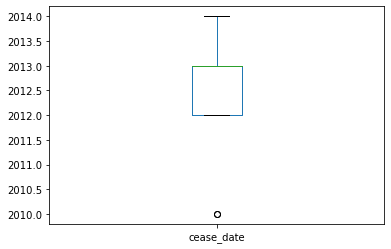

In [76]:
dete_resignations['cease_date'].dropna().astype(int).plot(kind='box')

<AxesSubplot:>

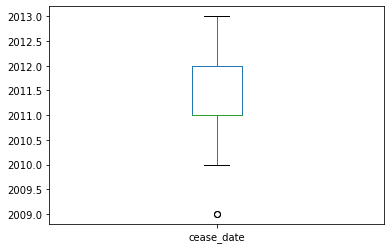

In [77]:
tafe_resignations['cease_date'].dropna().astype(int).plot(kind='box')

In [78]:
# check the unique values in the dete_start_date
dete_resignations['dete_start_date'].value_counts().sort_values()

1963.0     1
1971.0     1
1972.0     1
1984.0     1
1977.0     1
1987.0     1
1975.0     1
1973.0     1
1982.0     1
1974.0     2
1983.0     2
1976.0     2
1986.0     3
1985.0     3
2001.0     3
1995.0     4
1988.0     4
1989.0     4
1991.0     4
1997.0     5
1980.0     5
1993.0     5
1990.0     5
1994.0     6
2003.0     6
1998.0     6
1992.0     6
2002.0     6
1996.0     6
1999.0     8
2000.0     9
2013.0    10
2009.0    13
2006.0    13
2004.0    14
2005.0    15
2010.0    17
2012.0    21
2007.0    21
2008.0    22
2011.0    24
Name: dete_start_date, dtype: int64

In [73]:
# check unique values in the cease_date column
tafe_resignations['cease_date'].value_counts().sort_values()

2009      2
2013     55
2010     68
2012     94
2011    116
Name: cease_date, dtype: int64

we can verify:

- There aren't any major issues with the years.
- The years in each dataframe don't span quite the same number of years. 

Now that we've verified the years in the dete_resignations dataframe, we'll use them to create a new column. Recall that our end goal is to answer the following question:

Are employees who have only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been at the job longer?
In the Human Resources field, the length of time an employee spent in a workplace is referred to as their years of service.

You may have noticed that the tafe_resignations dataframe already contains a "service" column, which we renamed to institute_service. In order to analyze both surveys together, we'll have to create a corresponding institute_service column in dete_resignations.

Do we have data that can be used to calculate the length of time the employee spent in their workplace? Take a minute to review dete_resignations once more and see if you can answer this question before moving on.

In [85]:
dete_resignations['dete_start_date'].value_counts()

2011.0    24
2008.0    22
2007.0    21
2012.0    21
2010.0    17
2005.0    15
2004.0    14
2009.0    13
2006.0    13
2013.0    10
2000.0     9
1999.0     8
1996.0     6
2002.0     6
1992.0     6
1998.0     6
2003.0     6
1994.0     6
1993.0     5
1990.0     5
1980.0     5
1997.0     5
1991.0     4
1989.0     4
1988.0     4
1995.0     4
2001.0     3
1985.0     3
1986.0     3
1983.0     2
1976.0     2
1974.0     2
1971.0     1
1972.0     1
1984.0     1
1982.0     1
1987.0     1
1975.0     1
1973.0     1
1977.0     1
1963.0     1
Name: dete_start_date, dtype: int64

In [92]:
dete_resignations['institute_service'] = dete_resignations['cease_date'].fillna(2012).astype(int) - dete_resignations['dete_start_date']

In [93]:
dete_resignations['institute_service'].value_counts()

5.0     24
1.0     23
3.0     20
0.0     20
6.0     19
4.0     16
7.0     14
9.0     14
2.0     14
13.0     8
8.0      8
17.0     7
22.0     7
20.0     7
12.0     7
15.0     7
14.0     6
10.0     6
18.0     5
16.0     5
23.0     4
11.0     4
24.0     4
28.0     3
39.0     3
19.0     3
21.0     3
25.0     3
32.0     3
26.0     2
30.0     2
36.0     2
29.0     1
33.0     1
42.0     1
27.0     1
41.0     1
35.0     1
38.0     1
34.0     1
49.0     1
31.0     1
Name: institute_service, dtype: int64

We created a new institute_service column that we'll use to analyze survey respondents according to their length of employment in the dete_resignations dataframe in order to carry out our analysis because the tafe_resignations dataframe already contains a "service" column.

Identify Dissatisfied Employees

Next, we'll identify any employees who resigned because they were dissatisfied.

Below are the columns we'll use to categorize employees as "dissatisfied" from each dataframe.

1. tafe_survey_updated:
    - Contributing Factors. Dissatisfaction
    - Contributing Factors. Job Dissatisfaction
2. dete_survey_updated:
    - job_dissatisfaction
    - dissatisfaction_with_the_department
    - physical_work_environment
    - lack_of_recognition
    - lack_of_job_security
    - work_location
    - employment_conditions
    - work_life_balance
    - workload
If the employee indicated any of the factors above caused them to resign, we'll mark them as dissatisfied in a new column.

In [95]:
# viewing the values in the 'Contributing Factors. Dissatisfaction'
tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts()

-                                         277
Contributing Factors. Dissatisfaction      55
Name: Contributing Factors. Dissatisfaction, dtype: int64

In [96]:
# viewing the values in the 'Contributing Factors. Dissatisfaction'
tafe_resignations['Contributing Factors. Job Dissatisfaction'].value_counts()

-                      270
Job Dissatisfaction     62
Name: Contributing Factors. Job Dissatisfaction, dtype: int64

In [100]:
#create function to update tafe_resignations
def update_val(val):
    if pd.isnull(val):
        return np.nan 
    elif val == '-':
        return False
    else:
        return True

tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction','Contributing Factors. Job Dissatisfaction']].applymap(update_val).any(axis=1, skipna=False)
tafe_resignations_up = tafe_resignations

In [102]:
# Check the unique values after the updates
tafe_resignations_up['dissatisfied'].value_counts(dropna=False)

False    241
True      91
NaN        8
Name: dissatisfied, dtype: int64

In [104]:
# Create a dissatisfied column in dete_resignations dataframes.
dete_resignations['dissatisfied'] = dete_resignations[['job_dissatisfaction',
'dissatisfaction_with_the_department','physical_work_environment',
'lack_of_recognition','lack_of_job_security','work_location',
'employment_conditions','work_life_balance','workload']].any(axis=1, skipna=False)
dete_resignations_up = dete_resignations

# check the unique values after the update
dete_resignations_up['dissatisfied'].value_counts(dropna=False)

False    162
True     149
Name: dissatisfied, dtype: int64

We've accomplished the following:

- Renamed our columns
- Dropped any data not needed for our analysis
- Verified the quality of our data
- Created a new institute_service column
- Cleaned the Contributing Factors columns
- Created a new column indicating if an employee resigned because they were dissatisfied in some way.

Combine The Data

Now, we're finally ready to combine our datasets! Our end goal is to aggregate the data according to the institute_service column.

In [108]:
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'

# combine dataframes
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True)

In [110]:
# drop columns not needed for the analysis
combined_update = combined.dropna(thresh=500, axis=1)

We added a new column named 'institute' to both of our updated dataframes with the values 'DETE' and 'TAFE' to their respective rows, we combined them together and then drop columns we don't need for our analysis.

Clean The Service Column

Now that we've combined our dataframes, we're almost at a place where we can perform some kind of analysis! First, though, we'll have to clean up the institute_service column. This column is tricky to clean because it currently contains values in a couple different forms.

To analyze the data, we'll convert these numbers into categories. We'll base our analysis on this article, which makes the argument that understanding employee's needs according to career stage instead of age is more effective.

We'll use the slightly modified definitions below:

- New: Less than 3 years at a company
- Experienced: 3-6 years at a company
- Established: 7-10 years at a company
- Veteran: 11 or more years at a company

In [111]:
# check the unique values
combined_update['institute_service'].value_counts(dropna=False)

NaN                   78
Less than 1 year      73
1-2                   64
3-4                   63
5-6                   33
11-20                 26
5.0                   24
1.0                   23
7-10                  21
0.0                   20
3.0                   20
6.0                   19
4.0                   16
2.0                   14
7.0                   14
9.0                   14
More than 20 years    10
8.0                    8
13.0                   8
12.0                   7
15.0                   7
17.0                   7
20.0                   7
22.0                   7
10.0                   6
14.0                   6
18.0                   5
16.0                   5
24.0                   4
11.0                   4
23.0                   4
25.0                   3
39.0                   3
28.0                   3
32.0                   3
19.0                   3
21.0                   3
30.0                   2
26.0                   2
36.0                   2


In [114]:
# extract years of service from each value in the institute service column
combined_update['institute_service_up'] = combined_update['institute_service'].astype('str').str.extract(r'(\d+)')
combined_update['institute_service_up'] = combined_update['institute_service_up'].astype('float')

In [115]:
# check the years extracted are correct
combined_update['institute_service_up'].value_counts(dropna=False)

1.0     160
3.0      83
NaN      78
5.0      57
7.0      35
11.0     30
0.0      20
6.0      19
20.0     17
4.0      16
9.0      14
2.0      14
13.0      8
8.0       8
15.0      7
22.0      7
17.0      7
12.0      7
10.0      6
14.0      6
16.0      5
18.0      5
24.0      4
23.0      4
21.0      3
39.0      3
25.0      3
28.0      3
19.0      3
32.0      3
36.0      2
30.0      2
26.0      2
42.0      1
29.0      1
35.0      1
27.0      1
41.0      1
49.0      1
38.0      1
34.0      1
33.0      1
31.0      1
Name: institute_service_up, dtype: int64

In [116]:
# create a function to map years to career stage
def map_service(val):
    if val >= 11:
        return 'Veteran'
    elif 7 <= val <= 10:
        return 'Established'
    elif 3<= val <= 6:
        return 'Experienced'
    elif pd.isnull(val):
        return np.nan
    else:
        return 'New'

combined_update['service_cat'] = combined_update['institute_service_up'].apply(map_service)

# check the update
combined_update['service_cat'].value_counts()

New            194
Experienced    175
Veteran        141
Established     63
Name: service_cat, dtype: int64

We created a service_cat column, that categorizes employees according to the amount of years spent in their workplace:

- New: Less than 3 years at a company.
- Experienced: 3-6 years at a company.
- Established: 7-10 years at a company.
- Veteran: 11 or more years at a company.

Perform Initial Analysis

Finally, we'll replace the missing values in the dissatisfied column with the most frequent value, False. Then, we'll calculate the percentage of employees who resigned due to dissatisfaction in each service_cat group and plot the results.

Note that since we still have additional missing values left to deal with, this is meant to be an initial introduction to the analysis, not the final analysis.

In [117]:
# check the number of true cand false in the dissatisfaction oclumn
combined_update['dissatisfied'].value_counts(dropna=False)

False    403
True     240
NaN        8
Name: dissatisfied, dtype: int64

In [118]:
# replace the missing values in the dissatisfied column with the most frequently occurring value.
combined_update['dissatisfied'] = combined_update['dissatisfied'].fillna(False)

<AxesSubplot:xlabel='service_cat'>

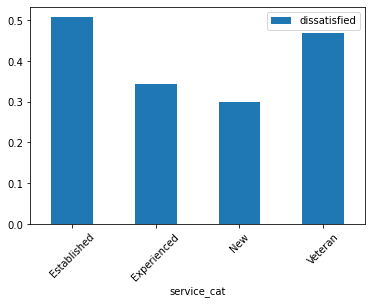

In [120]:
# calculate the percentage of dissatisfation of employees in each service group
percentage = combined_update.pivot_table(values='dissatisfied', index='service_cat')

# plot results
%matplotlib inline
percentage.plot(kind='bar', rot=45, xlim=(0,0.6))

From the initial analysis above, we can tentatively conclude that employees with 7 or more years of service are more likely to resign due to some kind of dissatisfaction with the job than employees with less than 7 years of service. However, we need to handle the rest of the missing data to finalize our analysis.

Our work here is far from done! We could continue with the following steps:

- Decide how to handle the rest of the missing values. Then, aggregate the data according to the service_cat column again.
- How many people in each career stage resigned due to some kind of dissatisfaction?
- Clean the age column. How many people in each age group resgined due to some kind of dissatisfaction?
- Instead of analyzing the survey results together, analyze each survey separately. Did more employees in the DETE survey or TAFE survey end their employment because they were dissatisfied in some way?
- Format your project using Dataquest's project style guide.